# **Objectives**
in this project, you will:
* load the data as a pandas dataframe
* cleann the data, taking care of the blank entries
* run exploratory data analysis(EDA) and identify the attributes that most affect the charges
* develop single variable and multi-variable Linear Regression Models for predictinf the charges
* Use Ridge regression to refine the performance of Linear regression models

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
df = pd.read_csv('/kaggle/input/medical-insurance-price-prediction/Medical_insurance.csv')
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [3]:
# replace the '?' entries with NaN values
df.replace('?',np.nan, inplace=True)

# **Data Wrangling**

In [4]:
#using info() to identify the columns that have some Null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


handling missing data:
* for continuous attributes (eg: age) replace missing values with the mean
* for categorical attributes(eg: smoker) replace missing values with the most frequent value
* update the data type of the respective columns
* verify the update using info()

In [5]:
# smoker is a categorical attribute, replace with most frequent entry
is_smoker = df['smoker'].value_counts().idxmax()
df["smoker"].replace(np.nan, is_smoker, inplace=True)

# age is a continuous variable, replace with mean age
mean_age = df['age'].astype('float').mean(axis=0)
df["age"].replace(np.nan, mean_age, inplace=True)

# Update data types
df["age"] = df["age"].astype(int)

try:
   df["smoker"] = df["smoker"].astype(int)
except ValueError as e:
    print(f"Error converting 'smoker' column to int: {e}")

#df[["age","smoker"]] = df[["age","smoker"]].astype("int")

print(df.info())

Error converting 'smoker' column to int: invalid literal for int() with base 10: 'yes'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
None


In [6]:
#update the charges column such that all values are rounded to nearest 2dp
df[['charges']] = np.round(df[["charges"]],2)
print(df.head())

   age     sex     bmi  children smoker     region   charges
0   19  female  27.900         0    yes  southwest  16884.92
1   18    male  33.770         1     no  southeast   1725.55
2   28    male  33.000         3     no  southeast   4449.46
3   33    male  22.705         0     no  northwest  21984.47
4   32    male  28.880         0     no  northwest   3866.86


# **Exploratory Data Analysis**

(0.0, 66902.85800000001)

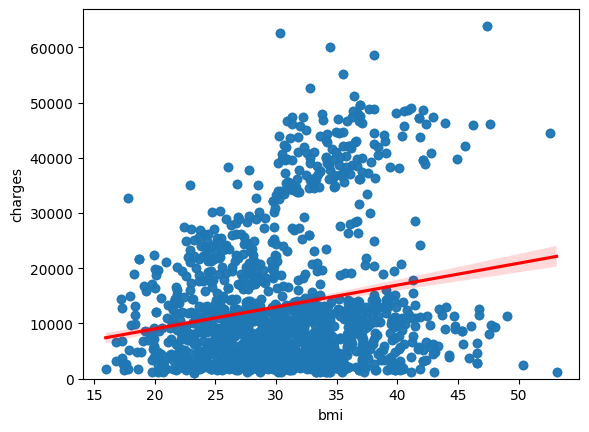

In [7]:
#implement the regression plot for charges with respect to bmi
sns.regplot(x="bmi", y="charges", data=df, line_kws={"color":"red"})
plt.ylim(0,)

<Axes: xlabel='smoker', ylabel='charges'>

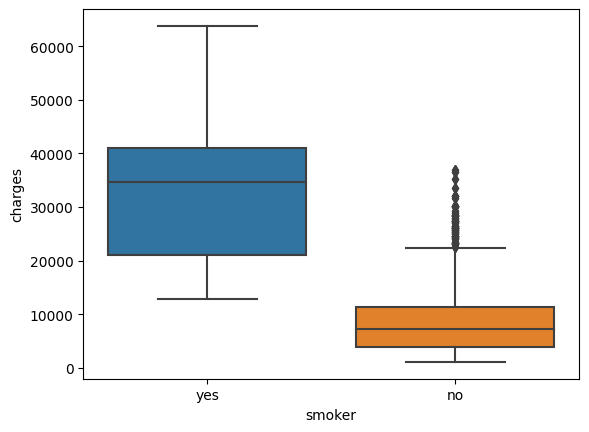

In [8]:
#implement the box plot for charges with respect to smoker
sns.boxplot(x="smoker", y="charges", data=df)

# **Model Development**

In [9]:
#fit a linear regression model that may be used to predict the charges value
# just by using the smoker attribute of the dataset.
#print the R^2 score of this model

X =df[['smoker']]
Y = df['charges']

# Create a transformer for one-hot encoding the 'smoker' column
preprocessor = ColumnTransformer(
    transformers=[('smoker', OneHotEncoder(), ['smoker'])],
    remainder='passthrough'
)

# Create a pipeline with the transformer and the linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

model.fit(X,Y)
print(model.score(X,Y))

0.6215176724160532


In [10]:
#fit a linear regression model that may be used to predict the charges value,
#just by using all other attributes of the dataset.
#print the R^2 score of this model

#create a new dataframe with one-hot encoded categorical variables
Z = pd.get_dummies(df[["age","sex","bmi","children","smoker","region"]])

#initialize the linear regression model
lm =LinearRegression()

lm.fit(Z,Y)
print(lm.score(Z,Y))

0.7509331529861025


In [11]:
#create a training pipeline that uses StandardScaler(), PolynomialFeatures() and LinearRegression()
#to create a model that can predict the charges value using all the other attributes of the dataset.

# Y and Z use the same values as defined in previous cells
Input =[('scale',StandardScaler()),('polynomial',
                                   PolynomialFeatures(include_bias=False)),('model',
                                                                          LinearRegression())]
pipe = Pipeline(Input)
Z = Z.astype(float)
pipe.fit(Z,Y)
ypipe =pipe.predict(Z)

#print  R^2 score
print(r2_score(Y,ypipe))

0.8473189075405922
